In [16]:
%matplotlib inline

import os
import sys
import copy
import time
import pickle
from array import array
import numpy as np
np.seterr(over='ignore')
import scipy as sp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, FloatSlider

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

# pycupid
from pycupid import *

# just for presentation
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Synthetic example

Gaussian function:
$$
f(x,y) = A \cdot \exp \left(- \left( a(x-x_0)^2 - 2b(x-x_0)(y-y_0) + c(y-y_0)^2 \right) \right)
$$

In [3]:
def gaussian2D(A, mu, sig, dims=(200,200)):
    x = np.linspace(0., 1., dims[0]+2)[1:-1]
    y = np.linspace(0., 1., dims[1]+2)[1:-1]
    X,Y = np.meshgrid(x,y)
    _X = X-mu[0]
    _Y = Y-mu[1]
    a = sig[0]; b=sig[1]; c=sig[2]
    return A * np.exp(- (a*_X**2 - 2*b*_X*_Y + c*_Y**2))

In [4]:
np.random.seed(0)

g0 = gaussian2D(0.20, [0.7,0.3], [400,20,200])
g1 = gaussian2D(0.20, [0.63,0.35], [600,75,50])
g2 = gaussian2D(0.22, [0.52,0.38], [100,20,200])
g3 = gaussian2D(0.13, [0.6,0.2], [800,10,900])
g4 = gaussian2D(0.17, [0.78,0.3], [1000,20,900])
g5 = gaussian2D(0.17, [0.72,0.42], [800,30,1000])
g6 = gaussian2D(0.17, [0.40,0.75], [100,20,70])
g7 = gaussian2D(0.21, [0.25,0.8], [80,20,100])

dims = (200,200)
noise_level = 0.01
noise = noise_level * np.abs(np.random.randn(*dims))
rms_noise = estimate_rms(noise)
var_noise = np.std(noise)**2

data = g0+g1+g2+g3+g4+g5+g6+g7+noise
data -= data.min()
data /= data.max()

x = np.linspace(0., 1., data.shape[0]+2, endpoint=True)[1:-1]
y = np.linspace(0., 1., data.shape[1]+2, endpoint=True)[1:-1]
dfunc = RegularGridInterpolator((x,y), data, method='linear', bounds_error=False, fill_value=0.)

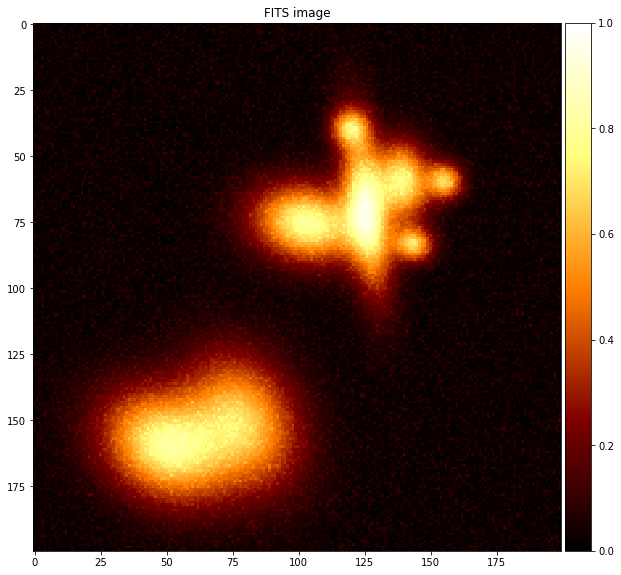

In [5]:
image_plot(data)

In [6]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level*0.5 ,max=1.,step=0.01,value=base_level))

Widget Javascript not detected.  It may not be installed or enabled properly.


<function graph.thresholded_image_plot>

***
***
***

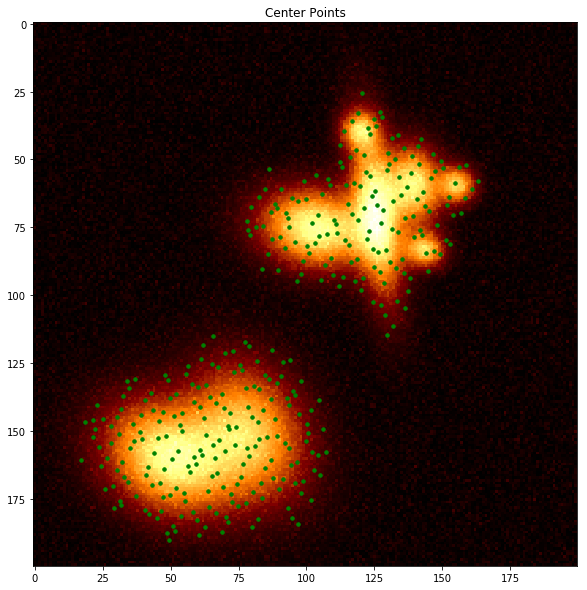

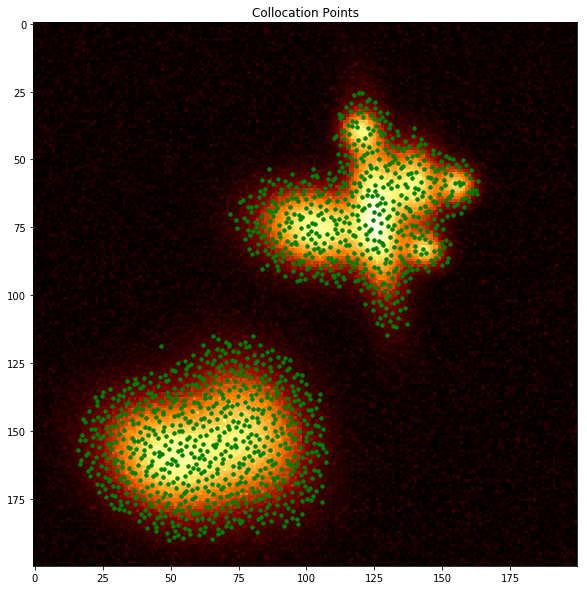

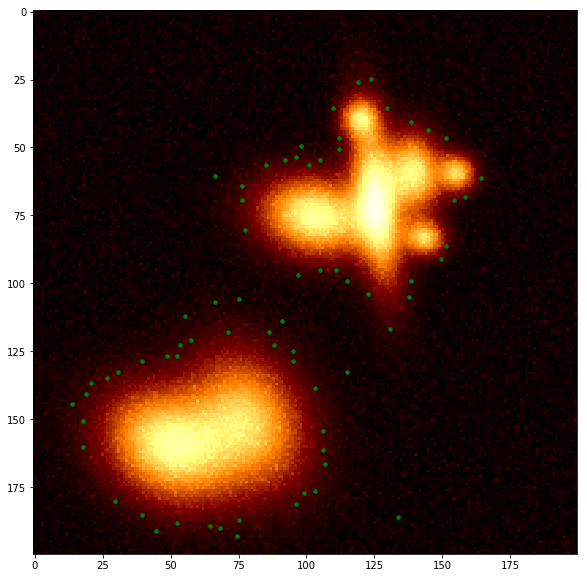

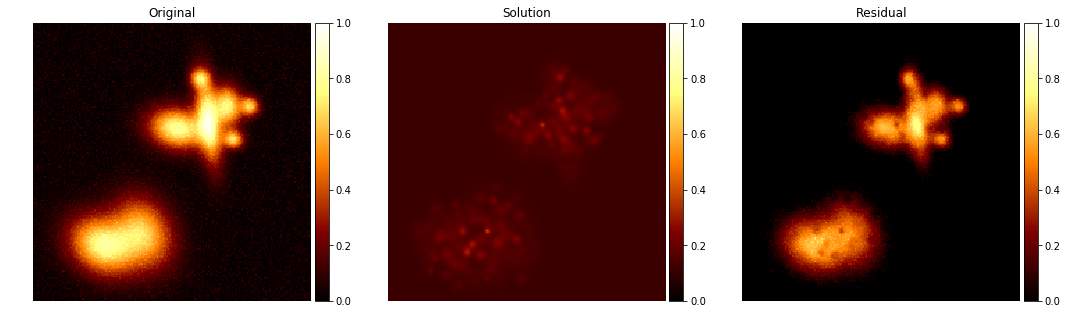

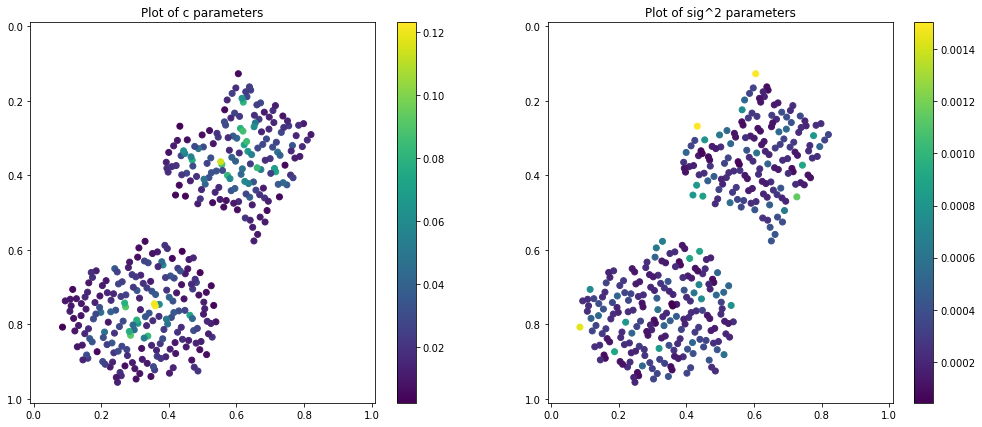

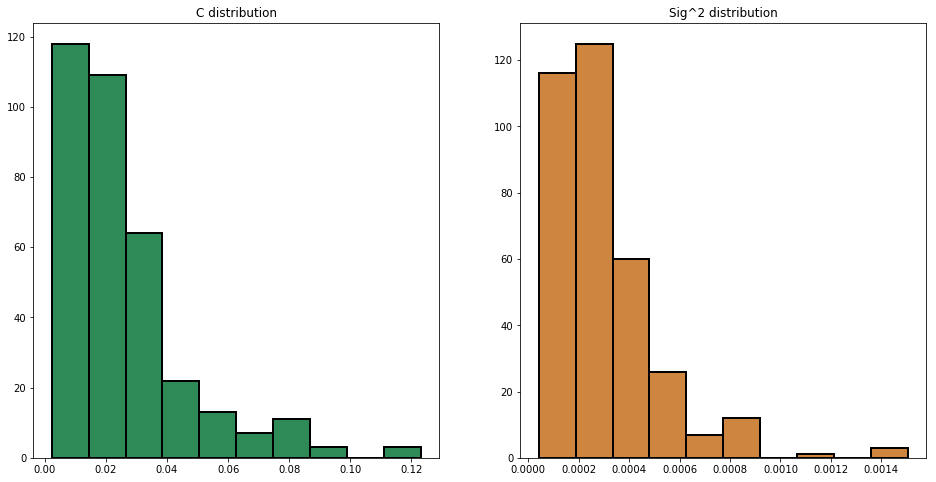

In [12]:
base_level = 0.1134
Nc = 350
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=1.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 50*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')


solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm01 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1.,
                base_level=base_level, pix_freedom=2., minsig=minsig, maxsig=maxsig)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 140100.
nfev: 140112

Residual stats:
Residual RMS: 0.02266883646851939
Residual Variance: 0.0005056954458431681
Flux Lost: 0.025631661375201665
Flux Addition: 0.018373170522291336
psi1(u-f): 0.3668795932532929
Exceeded Pixels: 5083
Sharpness: 271.6899123712292
psi2(grad u): 267.20919523579244
Total elapsed time: 790.9949760437012 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.06336445895694788
Mean min distance between collocation and center points: 0.012658450435315315

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.0818584165600354
Max min distance in the (standarized) parameters space: 0.29077436336692924


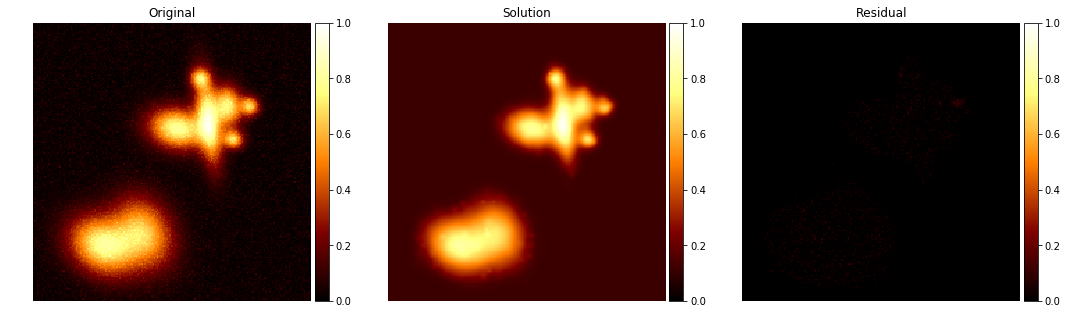

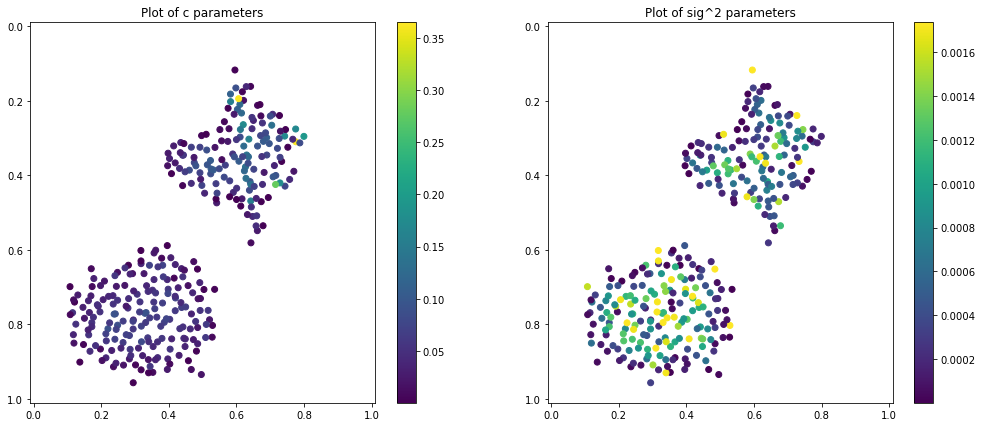

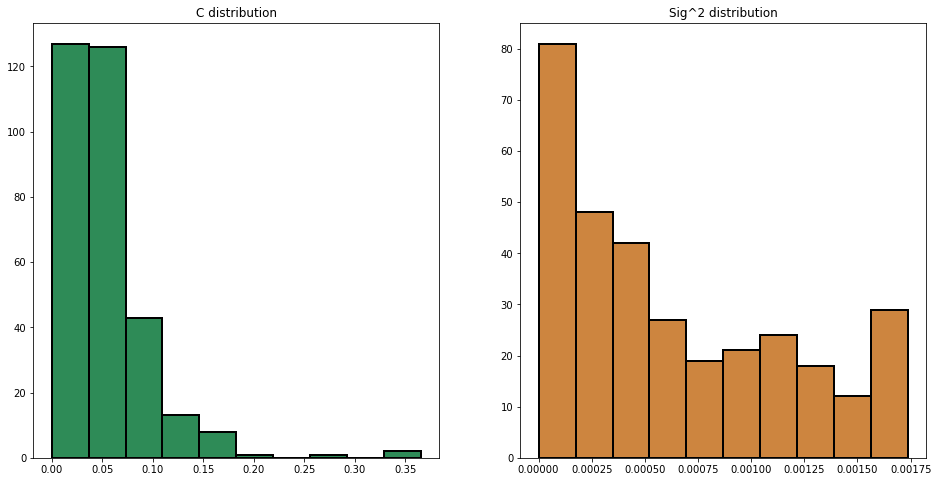

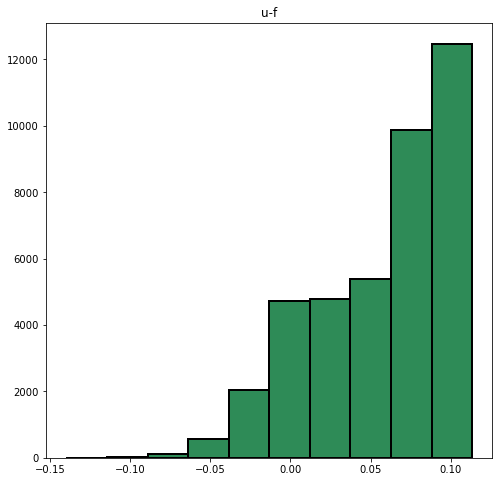

In [13]:
nfev = 100*(len(elm01.get_params())+1)
elm_solver(elm01, method='standard', max_nfev=nfev)

In [8]:
xc, yc, c, sig = elm01.get_params_mapped()
w = elm01.get_w()
mu = np.vstack([xc, yc]).T

In [9]:
components_dict01, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 8 and 172 with 1.4409314628269337e-07 KL dist and 1.5650479079312938e-12 ISD dist
Merged components 61 and 127 with 1.448248808084772e-07 KL dist and 5.529665024962088e-13 ISD dist
Merged components 154 and 179 with 2.0078792405789944e-07 KL dist and 7.045971914832055e-13 ISD dist
Merged components 64 and 92 with 4.2235860246361834e-07 KL dist and 4.124532552408778e-12 ISD dist
Merged components 25 and 91 with 4.320509717536211e-07 KL dist and 4.213854201317246e-12 ISD dist
Merged components 1 and 176 with 6.216482849011502e-07 KL dist and 1.5128973594883981e-10 ISD dist
Merged components 105 and 123 with 6.39575581648319e-07 KL dist and 3.306364220870869e-11 ISD dist
Merged components 72 and 124 with 7.051893226895251e-07 KL dist and 6.214569294886823e-10 ISD dist
Merged components 116 and 183 with 8.215628168482727e-07 KL dist and 8.284198823177164e-12 ISD dist
Merged components 14 and 166 with 1.2141600976946515e-06 KL dist and 1.4488922988449836e-09 ISD dist
Merge

Merged components 54 and 61 with 6.197868725424903e-05 KL dist and 9.249412200020501e-08 ISD dist
Merged components 6 and 29 with 6.656482835556857e-05 KL dist and 1.3688357754976287e-07 ISD dist
Merged components 15 and 54 with 6.778657105772521e-05 KL dist and 7.019630790379181e-08 ISD dist
Merged components 7 and 16 with 6.822465591713005e-05 KL dist and 9.250415996029217e-08 ISD dist
Merged components 7 and 63 with 7.047472572208405e-05 KL dist and 1.2081402582405816e-07 ISD dist
Merged components 50 and 52 with 7.120686678966737e-05 KL dist and 1.930502337717352e-07 ISD dist
Merged components 6 and 78 with 7.144696739811682e-05 KL dist and 2.574423008509369e-07 ISD dist
Merged components 7 and 94 with 7.208244329885732e-05 KL dist and 6.796105034705021e-07 ISD dist
Merged components 16 and 39 with 7.264517834885877e-05 KL dist and 4.6419492501448495e-07 ISD dist
Merged components 21 and 43 with 7.581415098995709e-05 KL dist and 2.9135658651442867e-07 ISD dist
Merged components 11 

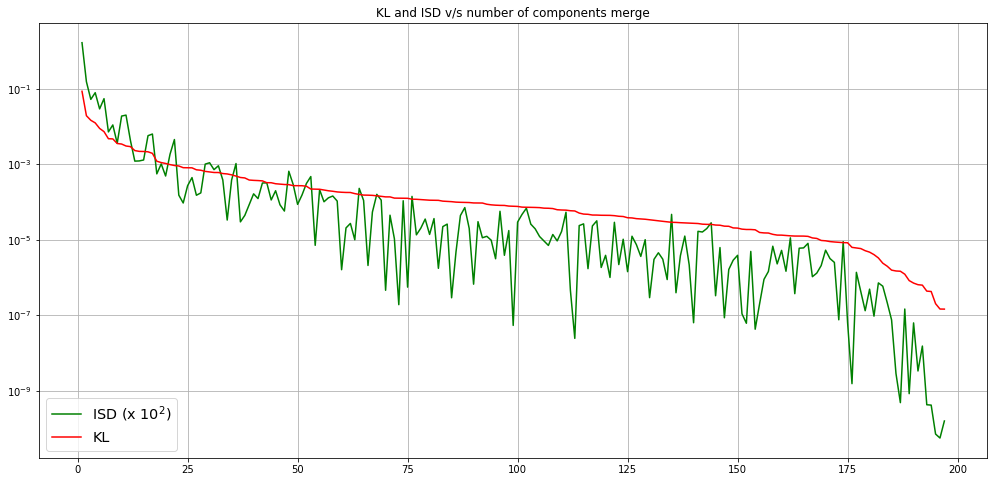

In [10]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.semilogy(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

In [11]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict01), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

<function graph.components_plot>

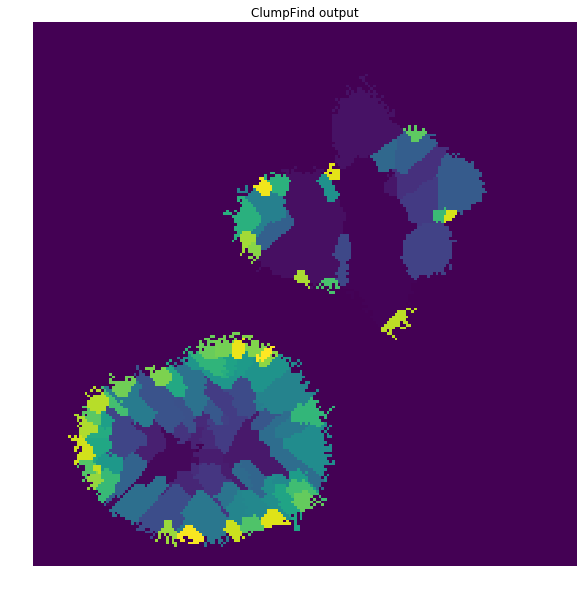

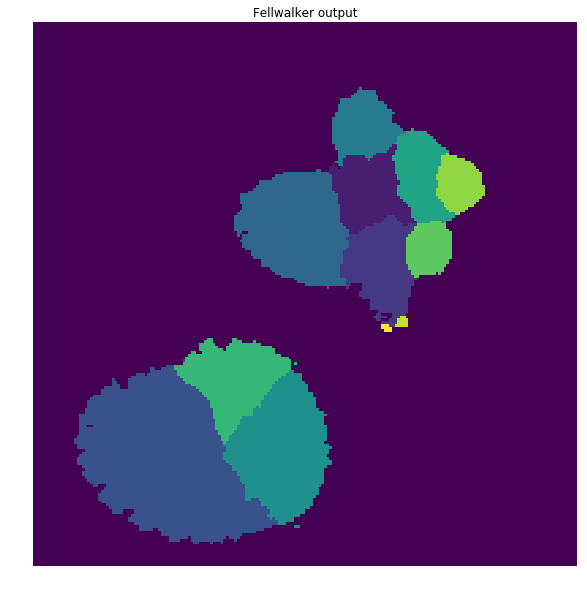

In [12]:
out_cf = clumpfind(data, 0.5*base_level)
out_cf[out_cf==out_cf.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('ClumpFind output')
plt.imshow(out_cf.T)
plt.axis('off')
plt.show()

out_fw = fellwalker(data, 0.5*base_level)
out_fw[out_fw==out_fw.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('Fellwalker output')
plt.imshow(out_fw.T)
plt.axis('off')
plt.show()

## Noise reduction capabilities

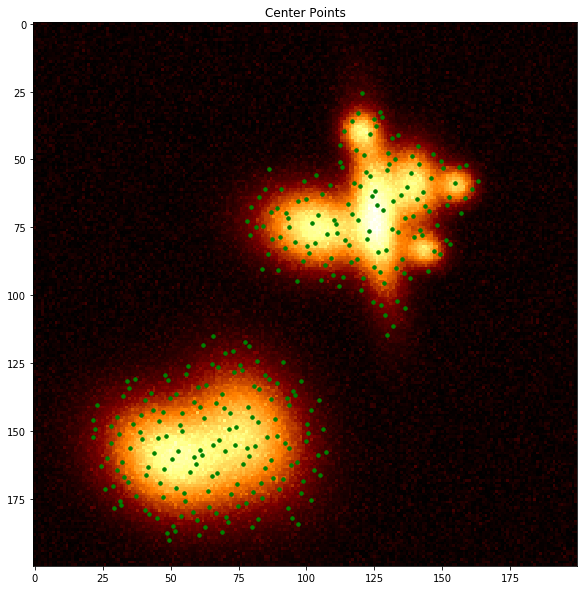

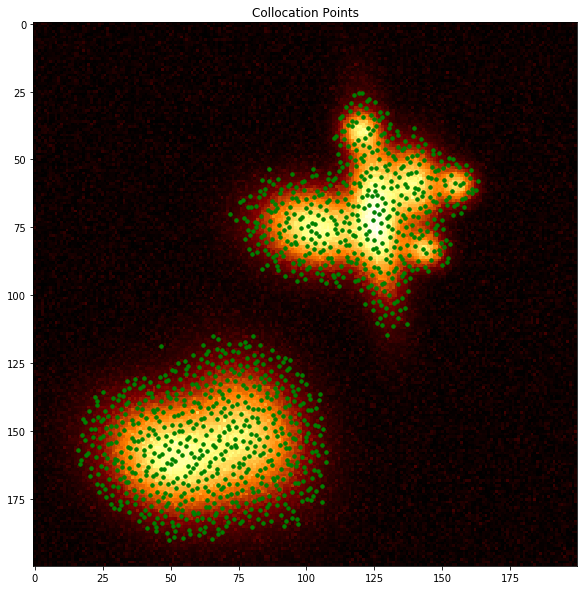

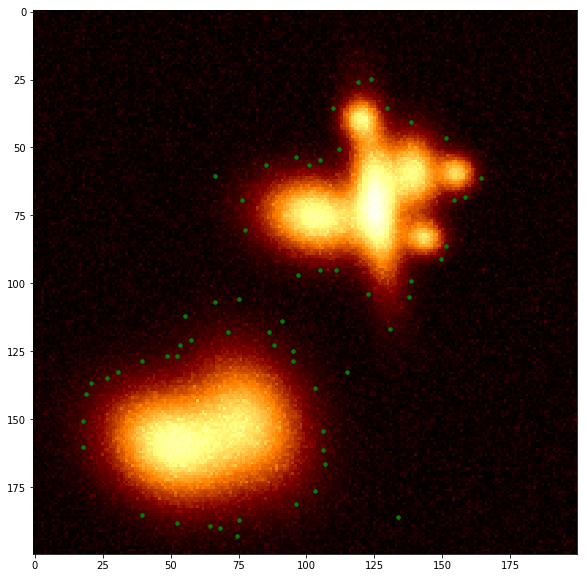

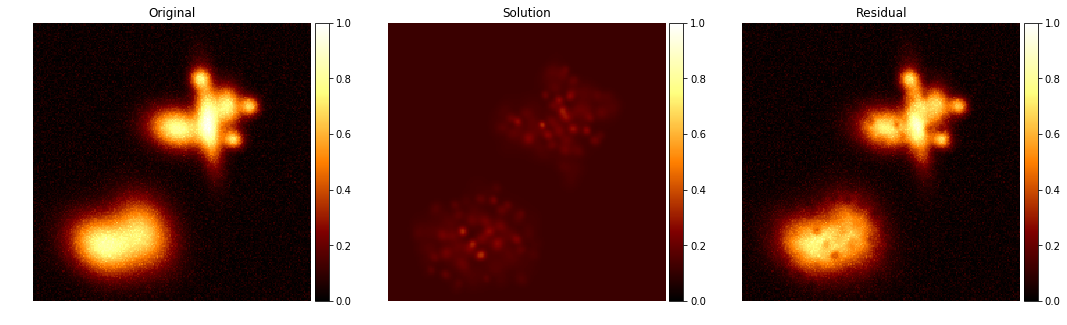

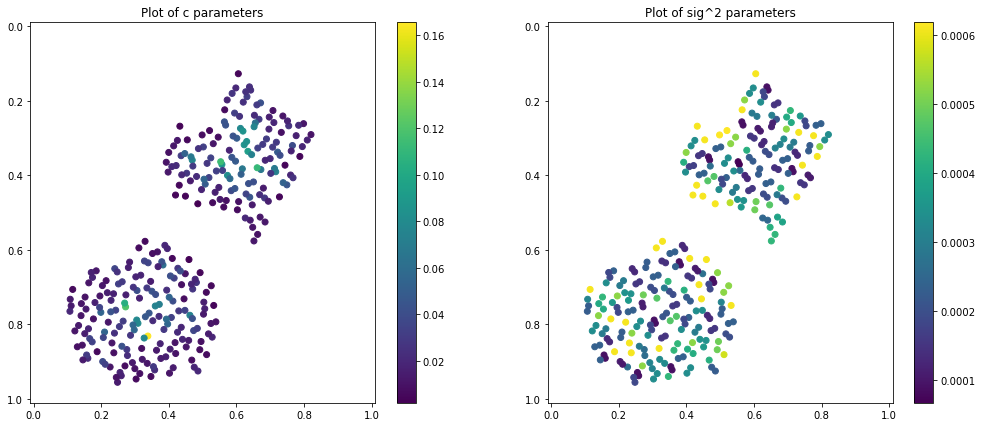

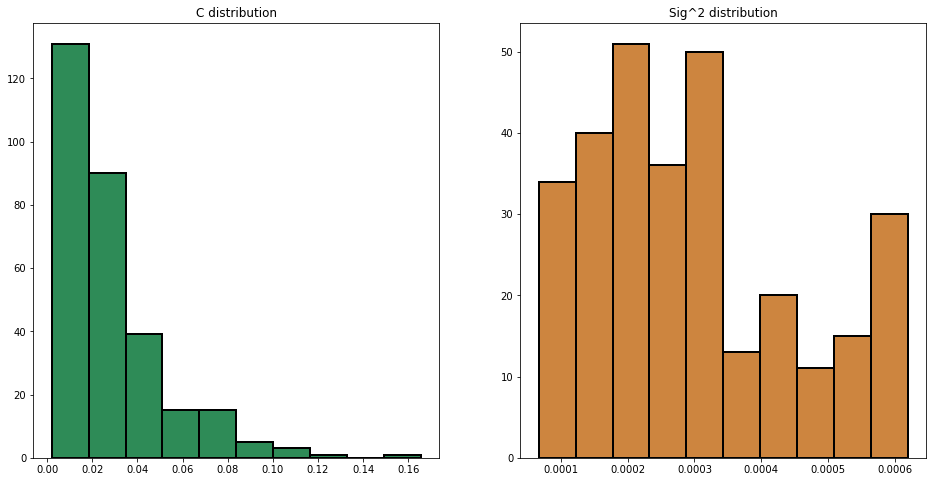

In [13]:
base_level = 0.1134
Nc = 300
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm02 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1.,
                base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 120100.
nfev: 120111

Residual stats:
Residual RMS: 0.025033724163417957
Residual Variance: 0.0006141848500799143
Flux Lost: 0.028097840202046406
Flux Addition: 0.01912459725892047
psi1(u-f): 0.4371920585389519
Exceeded Pixels: 5010
Sharpness: 266.6313141780466
psi2(grad u): 262.4856663329226
Total elapsed time: 455.43177914619446 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.05962720514944657
Mean min distance between collocation and center points: 0.013717294312241321

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.08921914275703555
Max min distance in the (standarized) parameters space: 0.3849482289019545


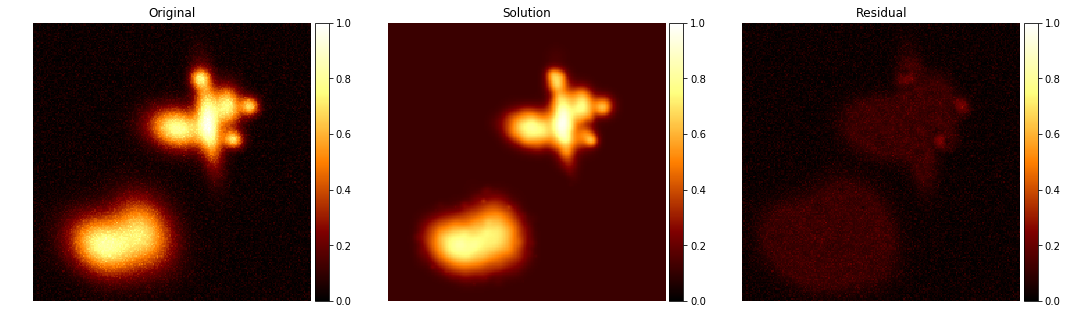

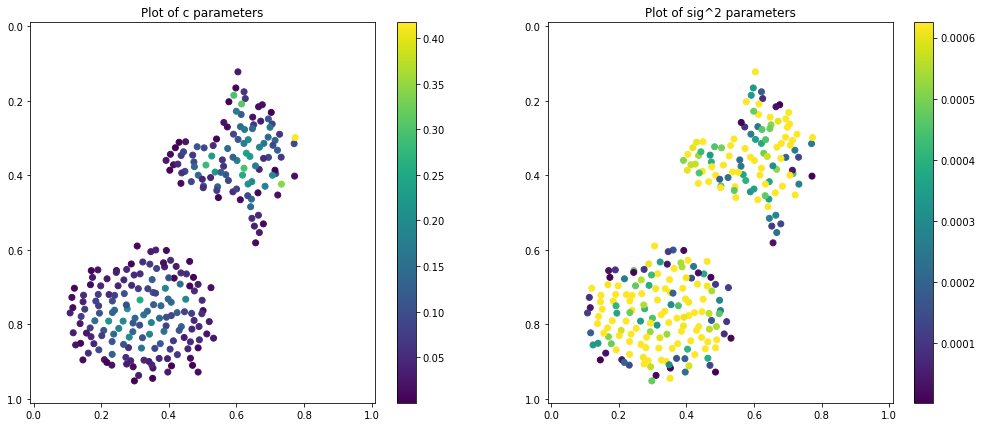

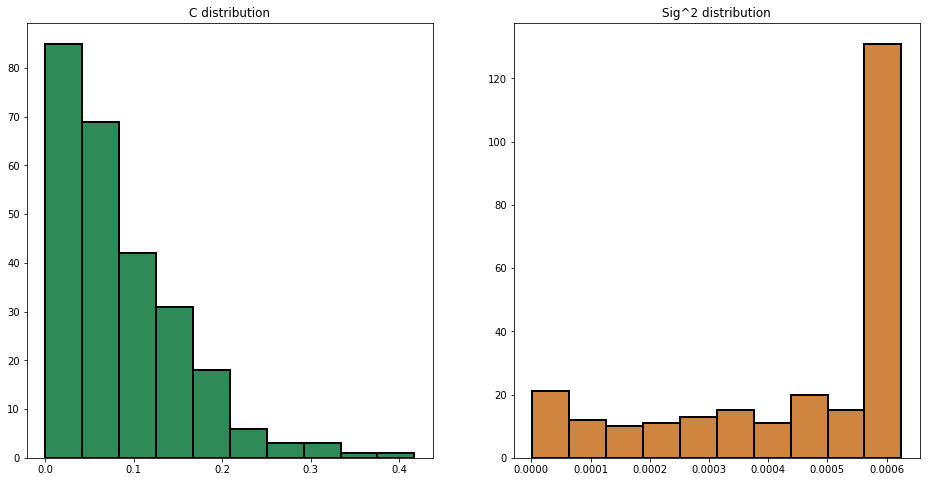

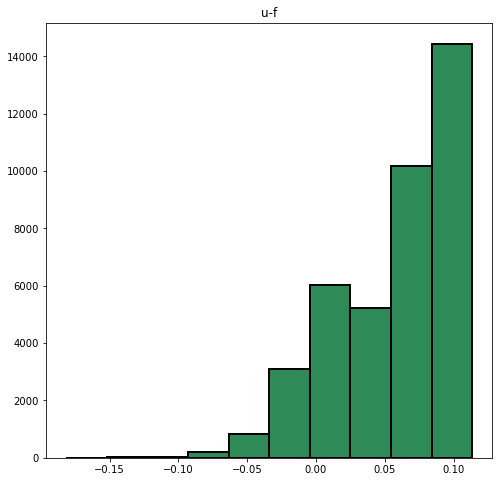

In [14]:
nfev = 100*(len(elm02.get_params())+1)
elm_solver(elm02, method='standard', max_nfev=nfev)

***
***
***

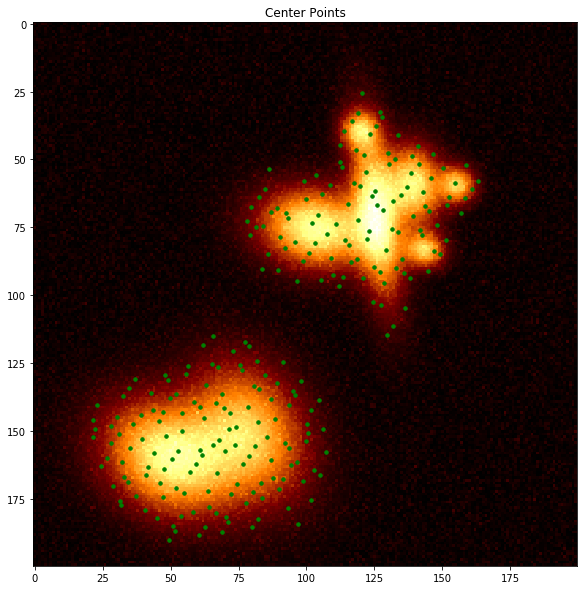

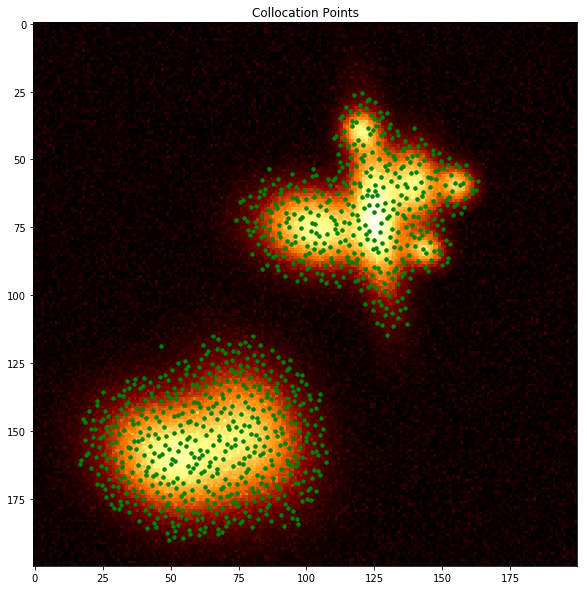

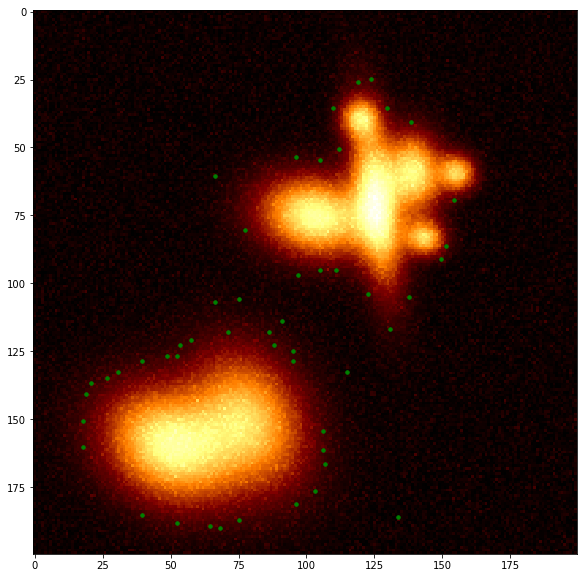

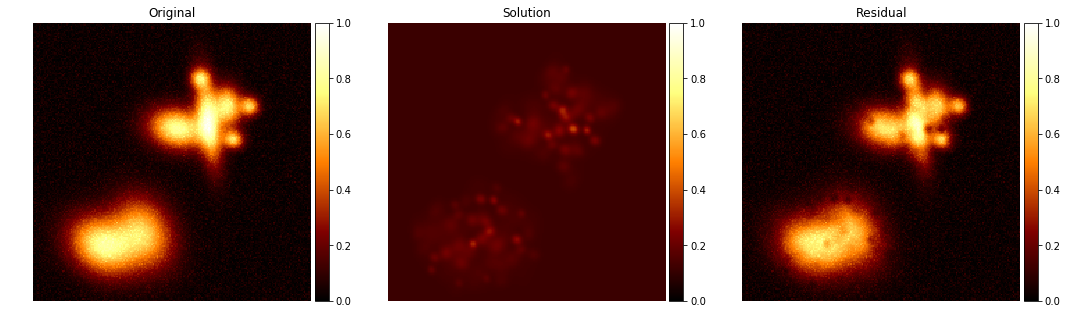

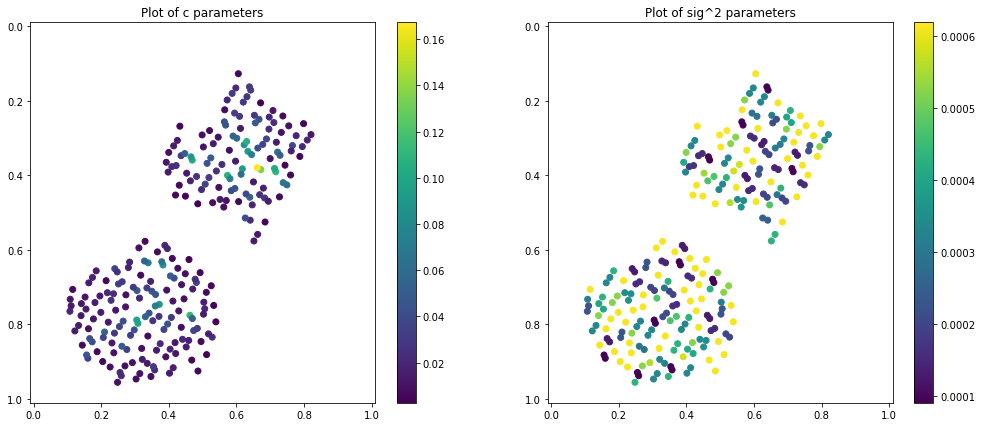

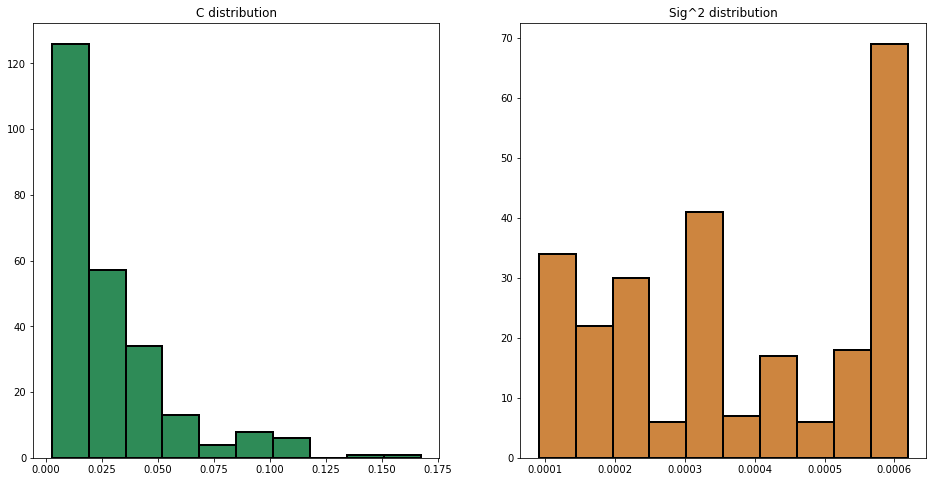

In [15]:
base_level = 0.1134
Nc = 250
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm03 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=10., lamb1=1.,
                base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)



 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100100.
nfev: 100115

Residual stats:
Residual RMS: 0.028457392177511222
Residual Variance: 0.0006956671911750068
Flux Lost: 0.03854209575044934
Flux Addition: 0.01142767041348022
psi1(u-f): 0.17494754915006008
Exceeded Pixels: 3845
Sharpness: 263.388303468971
psi2(grad u): 259.10263839556444
Total elapsed time: 280.2137563228607 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.05962720582020946
Mean min distance between collocation and center points: 0.014208251359407082

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.09701240008642881
Max min distance in the (standarized) parameters space: 0.2991522084767632


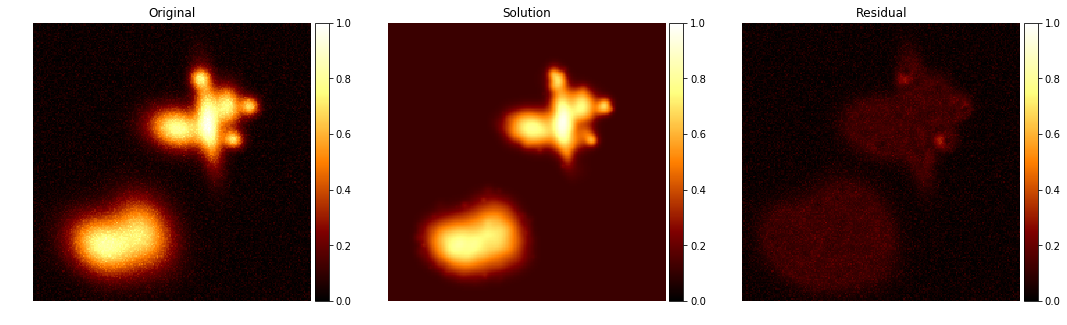

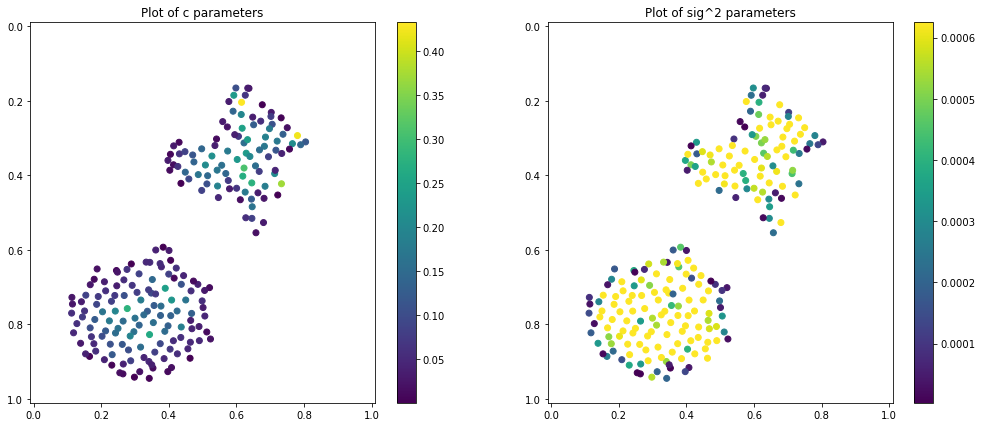

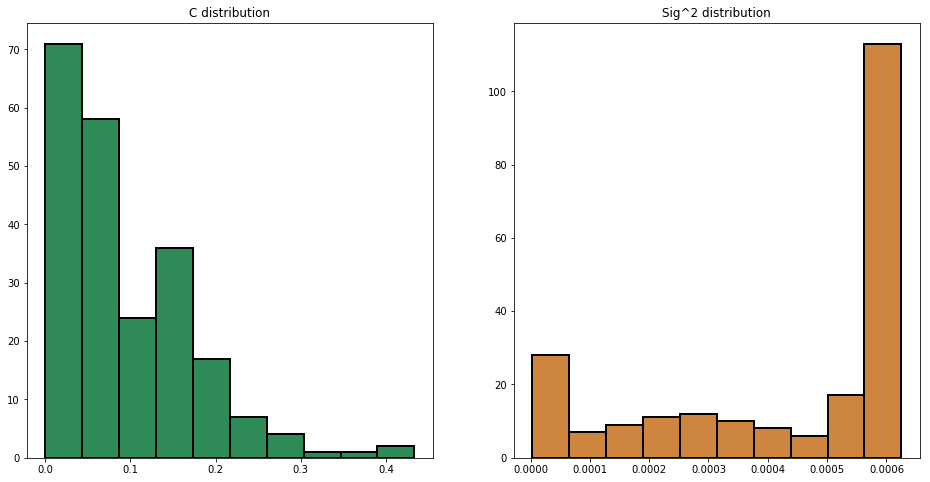

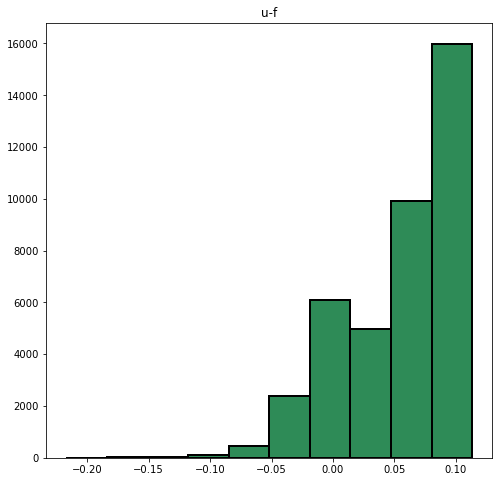

In [16]:
nfev = 100*(len(elm03.get_params())+1)
elm_solver(elm03, method='standard', max_nfev=nfev)

***
***
***

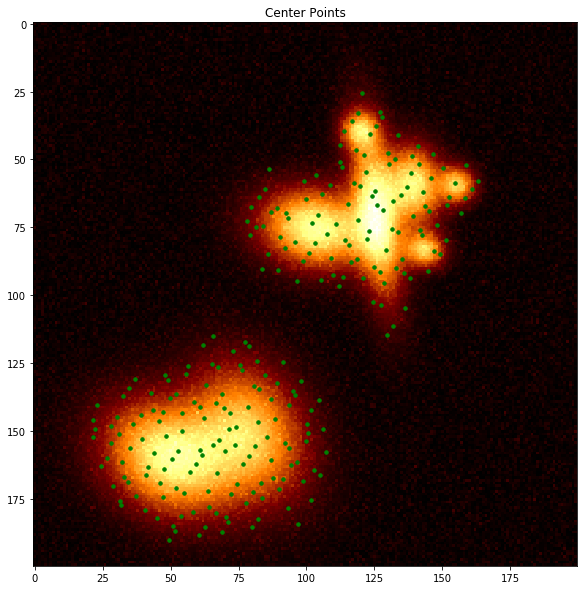

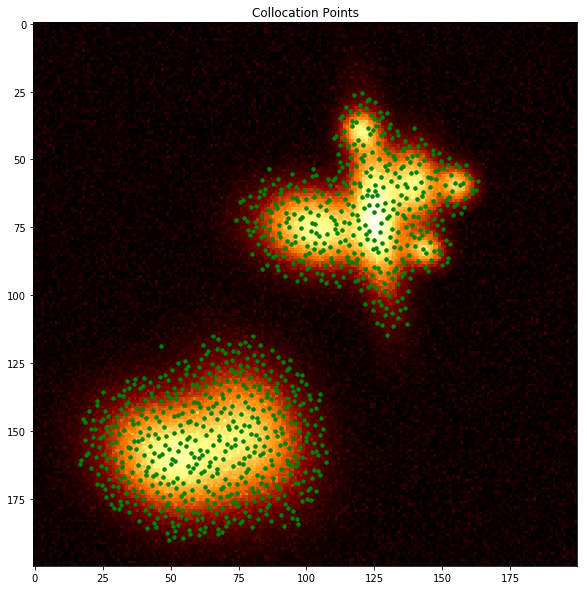

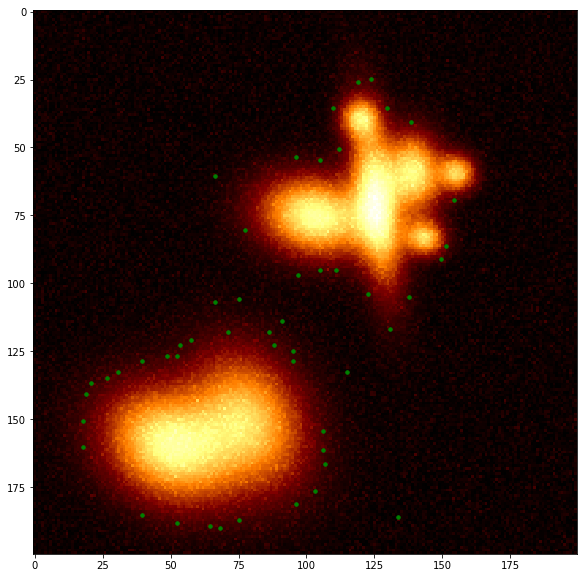

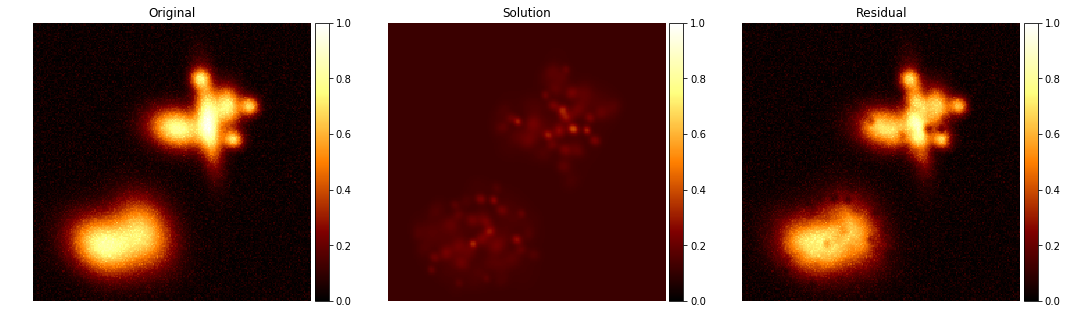

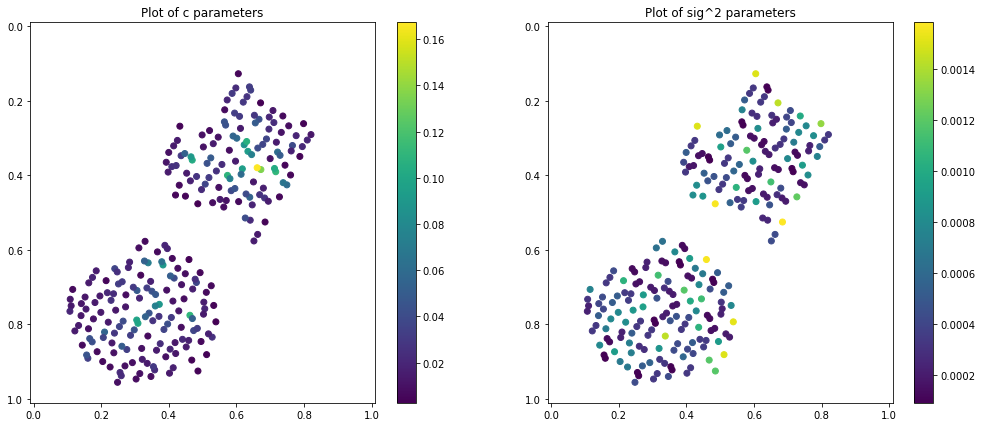

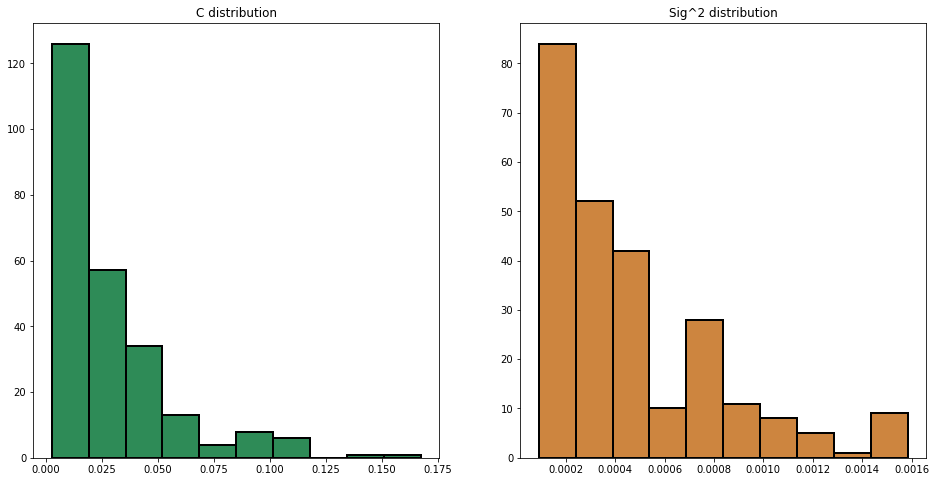

In [17]:
base_level = 0.1134
Nc = 250
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = 10*( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm04 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1.,
                base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)



 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100100.
nfev: 100108

Residual stats:
Residual RMS: 0.0239985504935473
Residual Variance: 0.0005620580818950537
Flux Lost: 0.027457354487136924
Flux Addition: 0.01800530476820861
psi1(u-f): 0.3555137671307837
Exceeded Pixels: 4973
Sharpness: 266.93683287732284
psi2(grad u): 262.66281377217007
Total elapsed time: 284.66416478157043 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.06411889707164548
Mean min distance between collocation and center points: 0.013460868183180113

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.08597965072033817
Max min distance in the (standarized) parameters space: 0.28414806334388026


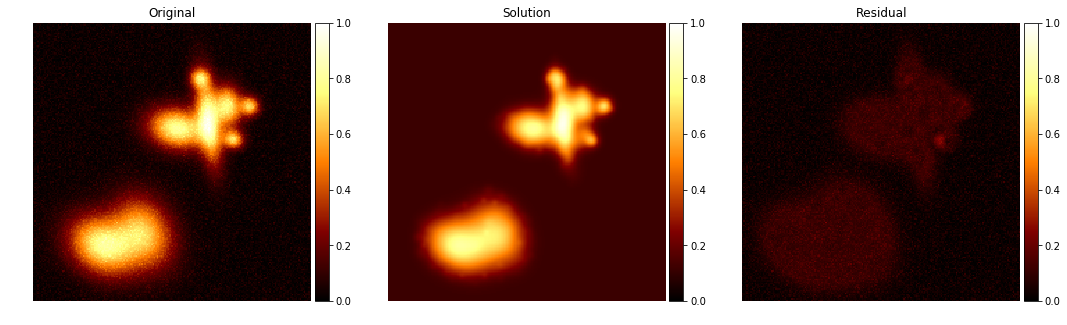

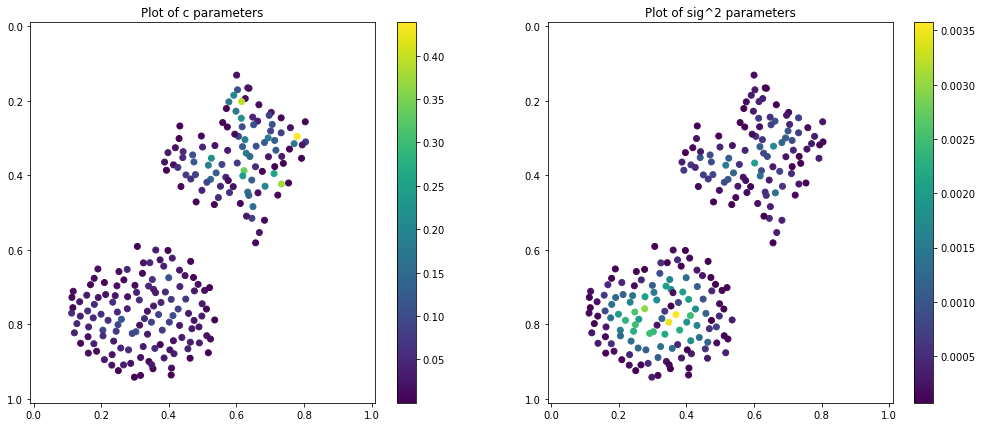

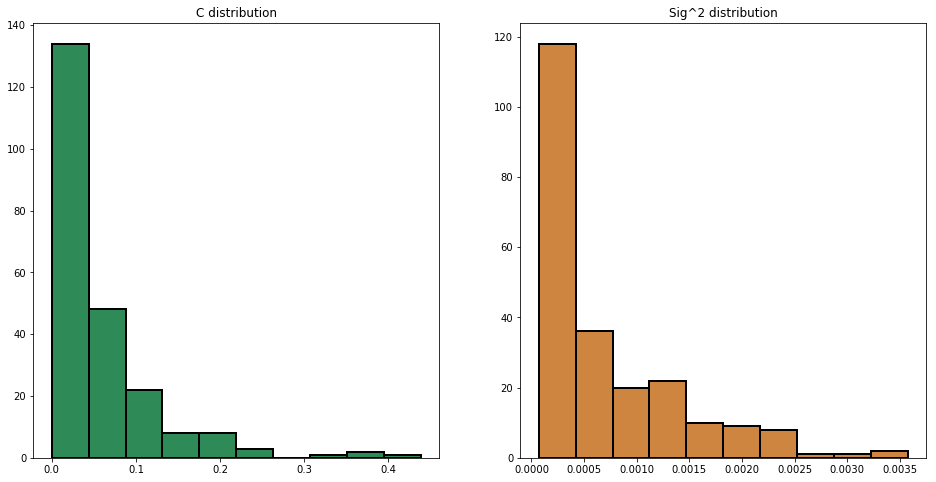

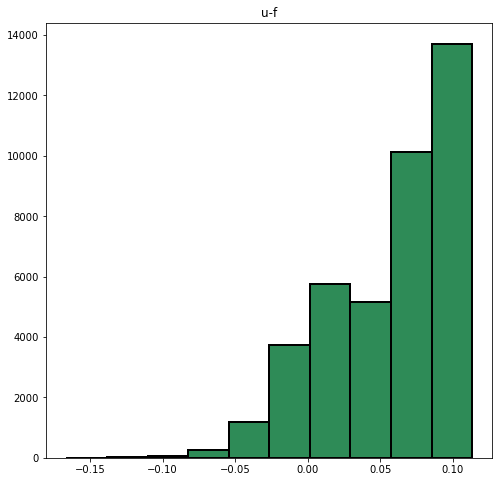

In [18]:
nfev = 100*(len(elm04.get_params())+1)
elm_solver(elm04, method='standard', max_nfev=nfev)

***
***
***

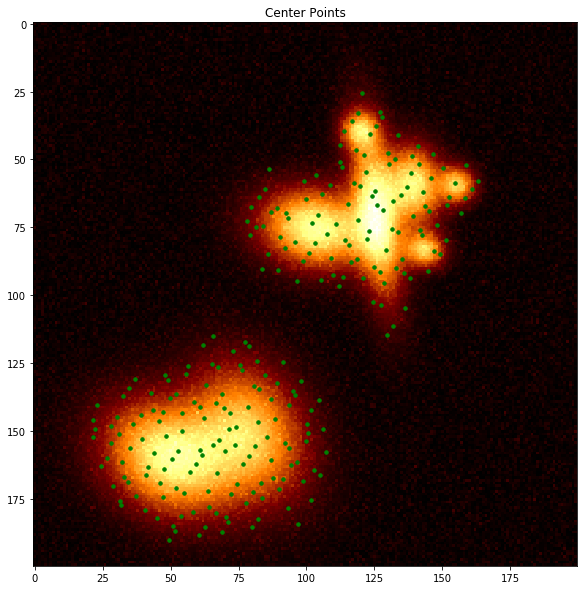

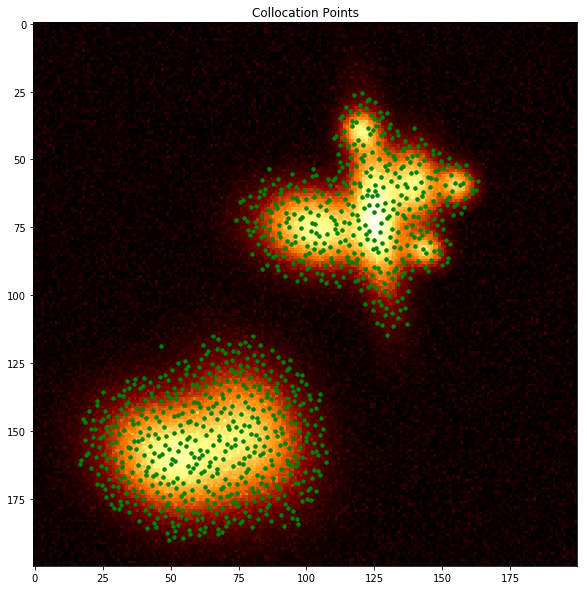

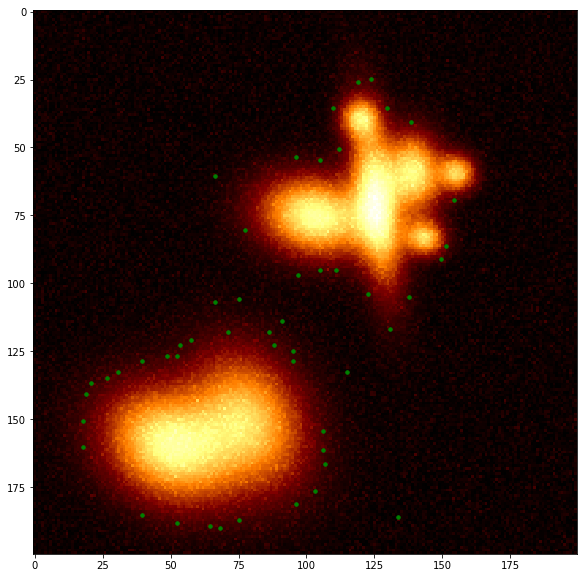

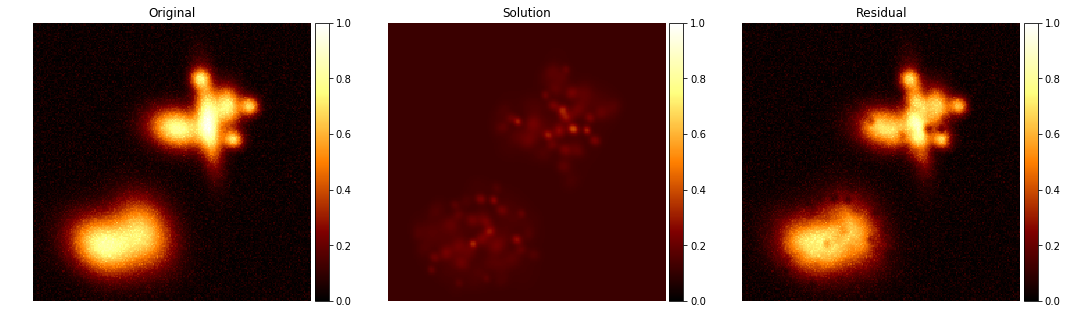

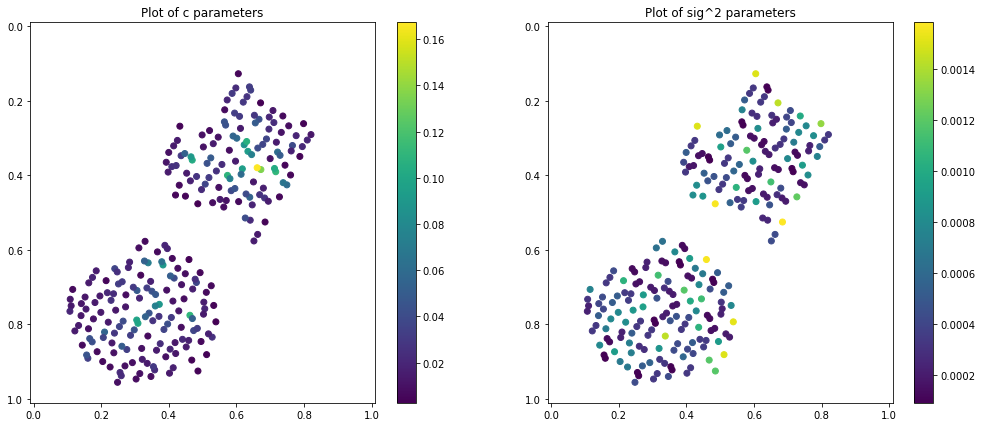

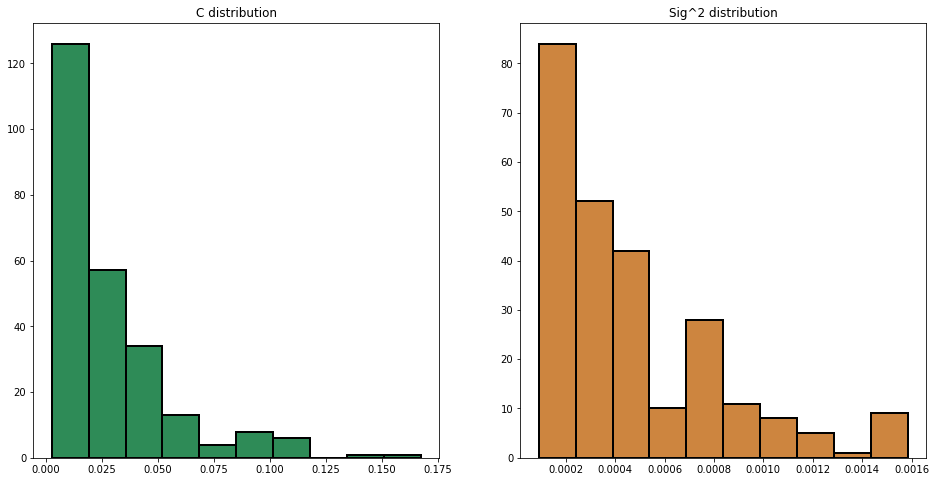

In [19]:
base_level = 0.1134
Nc = 250
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = 10*( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm05 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=10., lamb1=1.,
                base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)



 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100100.
nfev: 100111

Residual stats:
Residual RMS: 0.02751267776240876
Residual Variance: 0.0006482581115262394
Flux Lost: 0.03752979202268641
Flux Addition: 0.011072552916344092
psi1(u-f): 0.15846423790525274
Exceeded Pixels: 3802
Sharpness: 263.050537534507
psi2(grad u): 258.79036733970275
Total elapsed time: 284.45262598991394 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.04986048200816126
Mean min distance between collocation and center points: 0.013184536109232823

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.08100066065669659
Max min distance in the (standarized) parameters space: 0.2997516295318088


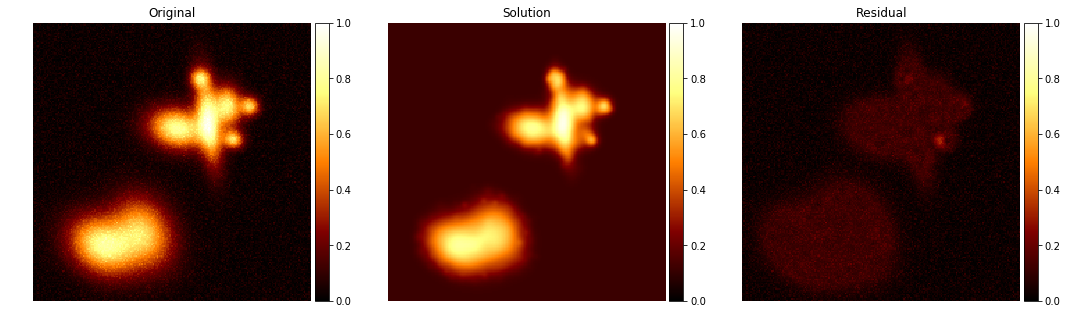

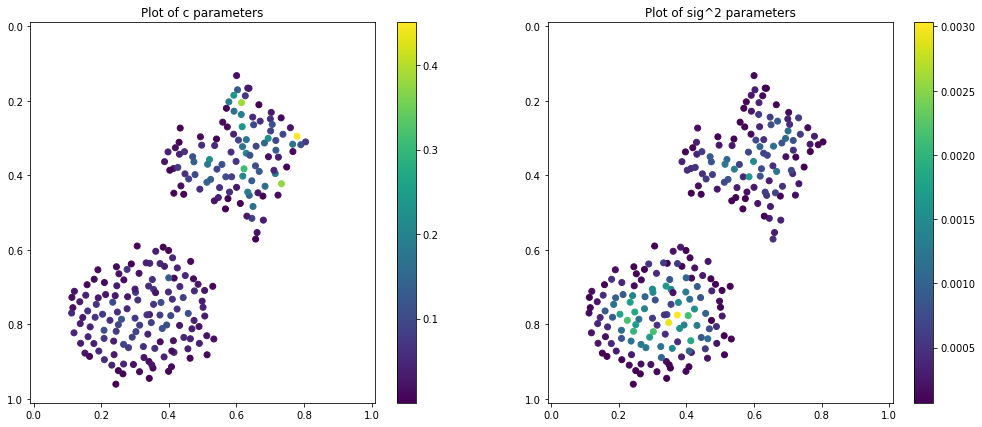

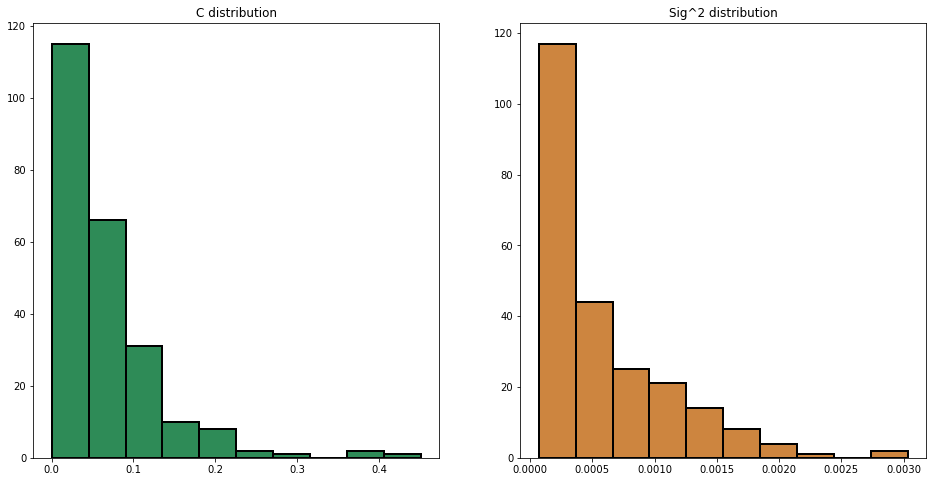

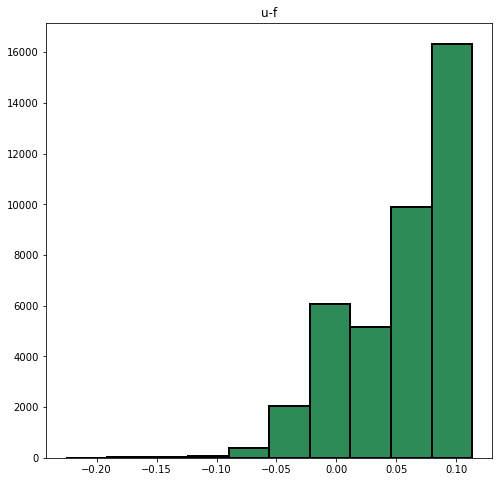

In [20]:
nfev = 100*(len(elm05.get_params())+1)
elm_solver(elm05, method='standard', max_nfev=nfev)

***
***
***

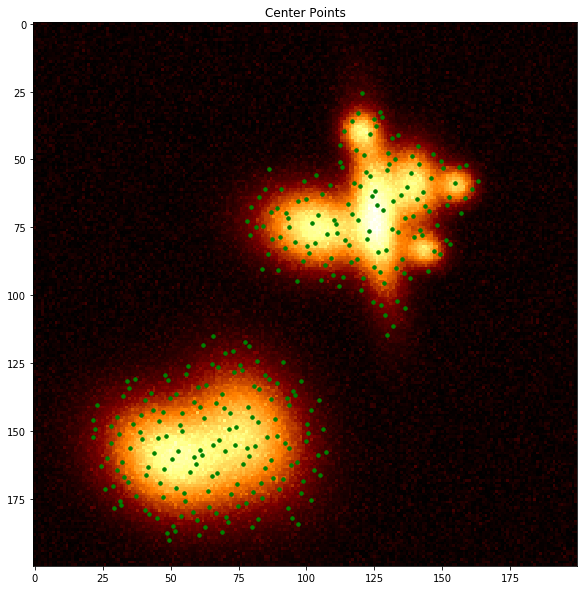

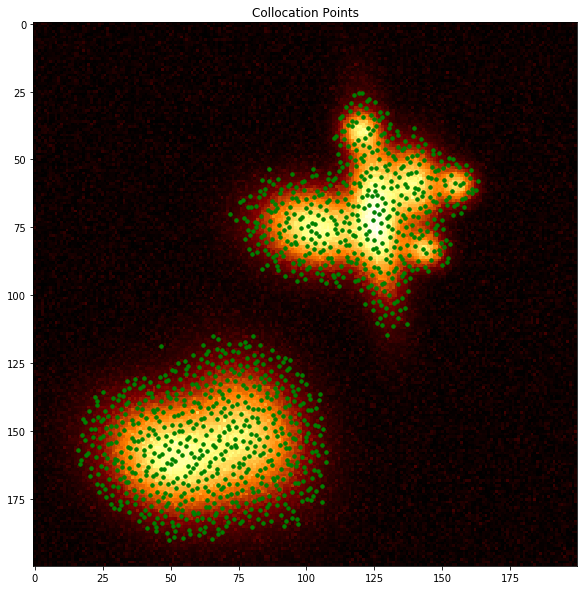

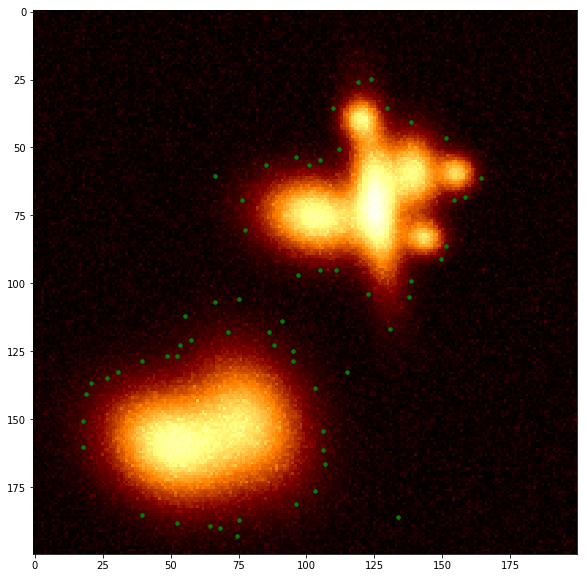

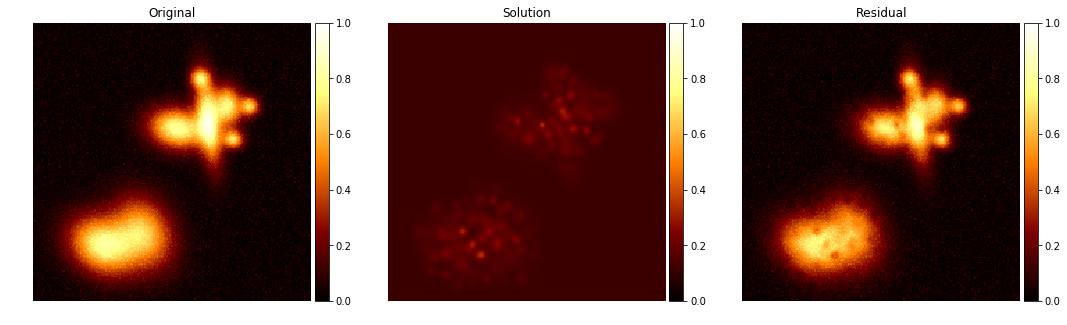

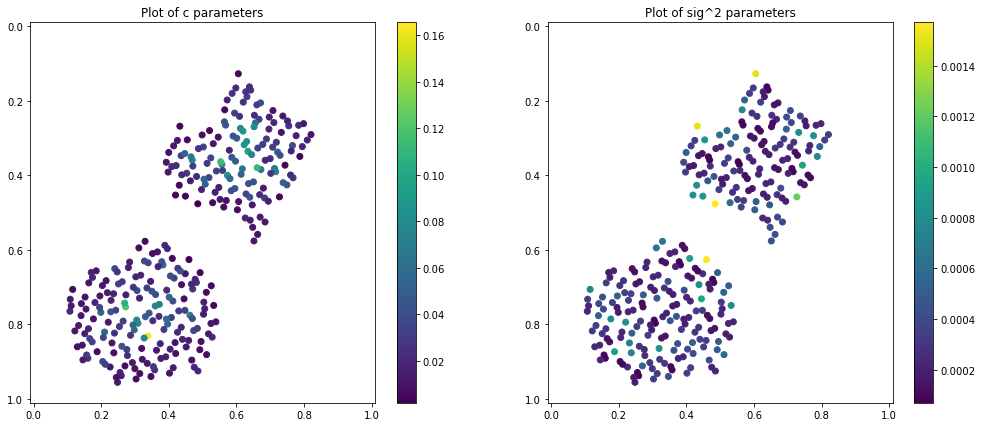

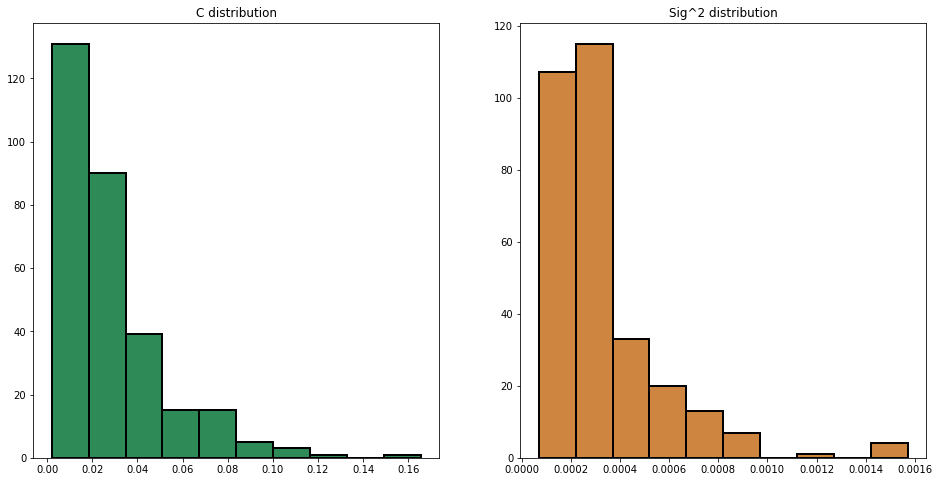

In [21]:
base_level = 0.1134
Nc = 300
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = 10*( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm06 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1.,
                base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)



 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 120100.
nfev: 120111

Residual stats:
Residual RMS: 0.024359994499123214
Residual Variance: 0.0005854659292276338
Flux Lost: 0.026789476610801406
Flux Addition: 0.019637034257956893
psi1(u-f): 0.41370790884275555
Exceeded Pixels: 5172
Sharpness: 266.09644630254695
psi2(grad u): 261.85042736558376
Total elapsed time: 471.75153732299805 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.05959345185775236
Mean min distance between collocation and center points: 0.013755939932809096

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.05303873310477259
Max min distance in the (standarized) parameters space: 0.2641842586304023


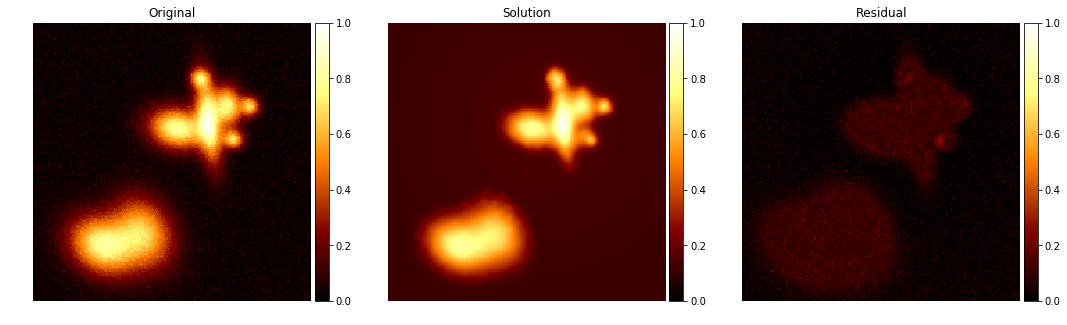

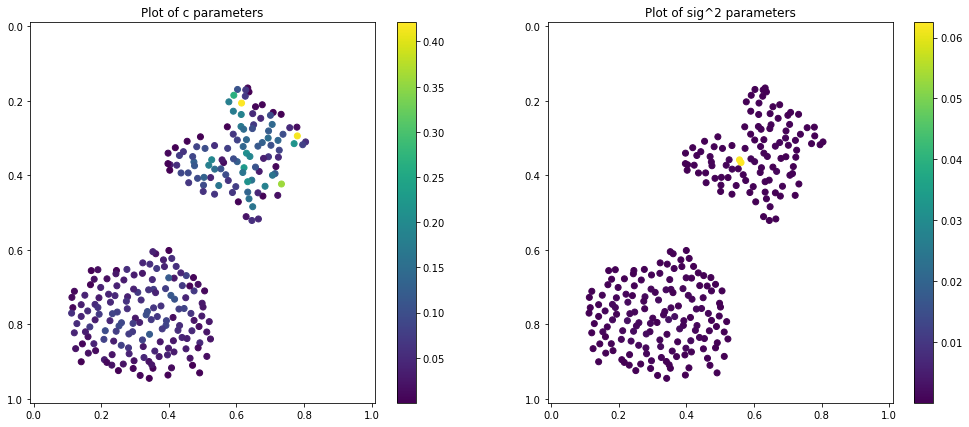

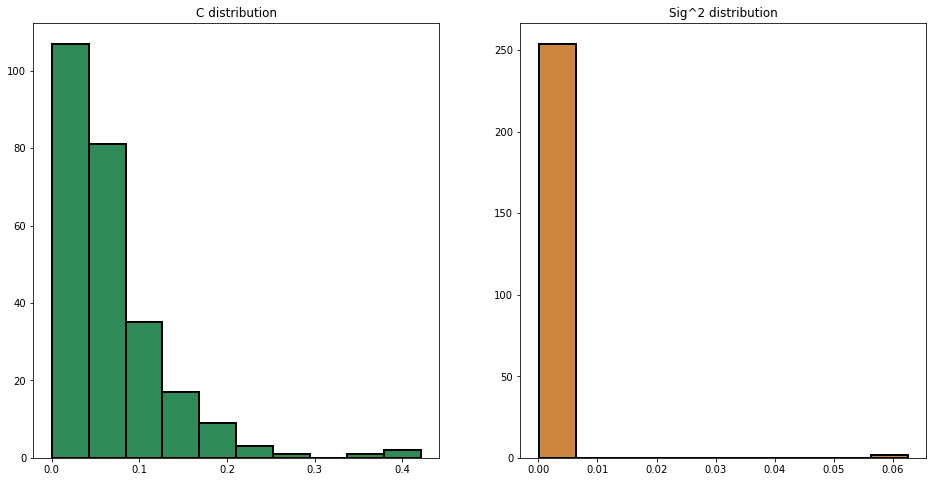

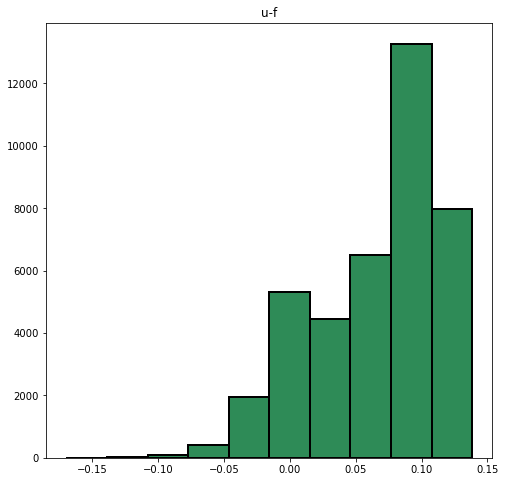

In [22]:
nfev = 100*(len(elm06.get_params())+1)
elm_solver(elm06, method='standard', max_nfev=nfev)

***
***
***

In [ ]:
Nc = 300
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb
base_level = 0.1134
alphas = np.arange(1., 20.01, 1.)
method=2

rms = []
mean = []
var = []

for alpha in alphas:
    if method==1:
        center_points = random_centers_generation(data, Nc, base_level=base_level, power=1.)
        collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
        boundary_points = boundary_points_generation(data, base_level, Nb)
    elif method==2:
        # points generation
        points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
        center_points = points[0:Nc]
        collocation_points = points[0:Ne]
        boundary_points = boundary_points_generation(data, base_level, Nb)   

    # right format
    xc = center_points[:,0]
    yc = center_points[:,1]
    xe = collocation_points[:,0]
    ye = collocation_points[:,1]
    xb = boundary_points[:,0]
    yb = boundary_points[:,1]

    # Initial parameters estimation
    minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
    maxsig = 50*minsig
    c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')


    elm = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=alpha, lamb1=1.,
                    base_level=base_level, pix_freedom=2., minsig=minsig, maxsig=maxsig)
    
    nfev = 100*(len(elm.get_params())+1)
    elm_solver(elm, method='standard', max_nfev=nfev)
    
    #########################################
    # Computing residual stats
    #########################################
    print("Alpha: {0}".format(alpha))
    u = elm.get_approximation()
    residual = data[elm.mask]-u[elm.mask]
    residual_rms = estimate_rms(residual); print("RMS of residual: {0}".format(residual_rms)); rms.append(residual_rms) 
    residual_mean = np.mean(residual); print("Mean of residual: {0}".format(residual_mean)); mean.append(residual_mean)
    residual_var = np.std(residual)**2; print("Variance of residual: {0} \n".format(residual_var)); var.append(residual_var)

In [ ]:
# storing results
f = open( "rms_residual.pkl", "wb" )
pickle.dump(rms, f); f.close()

f = open( "mean_residual.pkl", "wb" )
pickle.dump(mean, f); f.close()

f = open( "var_residual.pkl", "wb" )
pickle.dump(var, f); f.close()